In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from janome.tokenizer import Tokenizer

# データ読み込み

In [2]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
stations = pd.read_csv("station_list.csv")
id = test["id"]

In [3]:
#欠損値削除
train["reviews_per_month"] = train["reviews_per_month"].fillna(0)
train["last_review"] = train["last_review"].fillna("1900-01-01")
test["reviews_per_month"] = test["reviews_per_month"].fillna(0)
test["last_review"] = test["last_review"].fillna("1900-01-01")

In [4]:
!station_distance.py

distance.csv already existed


In [5]:
distance = pd.read_csv("distance.csv")
#adversarial validationのためのラベル付け
train["label"] = 1
test["label"] = 0
all_data = pd.concat([train,test],axis=0)
all_data["near_station"] = distance["near_station"]
all_data["dist_from_sta"] = distance["dist_from_sta"]
train.drop("label",axis=1,inplace=True)
test.drop("label",axis=1,inplace=True)

# 特徴量追加

In [6]:
#180日以上かどうか
train["180_over"] = (train["availability_365"] > 180).astype(int)
test["180_over"] = (test["availability_365"] > 180).astype(int)
all_data["180_over"] = (all_data["availability_365"] > 180).astype(int)

#英語かどうか
train["is_english"] = (train["name"].str.contains("[a-zA-Z]",regex=True) & ~train["name"].str.contains("[亜-熙ぁ-んァ-ン]",regex=True)).astype(int)
test["is_english"] = (test["name"].str.contains("[a-zA-Z]",regex=True) & ~test["name"].str.contains("[亜-熙ぁ-んァ-ン]",regex=True)).astype(int)
all_data["is_english"] = (all_data["name"].str.contains("[a-zA-Z]",regex=True) & ~all_data["name"].str.contains("[亜-熙ぁ-んァ-ン]",regex=True)).astype(int)
model = lgb.LGBMRegressor(random_state=1)
#one_hot_list = ["room_type","neighbourhood","minimum_nights","host_id_count"]
one_hot_list = ["room_type","neighbourhood","minimum_nights"]

In [7]:
#all_data[all_data["name"].str.contains("[ぁ-んァ-ン]",regex=True)]
#all_data[(all_data["name"].str.contains("[亜-熙]",regex=True) & ~all_data["name"].str.contains("[ぁ-んァ-ン\uFF61-\uFF9F]",regex=True))]

In [8]:
all_data.head()

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y,label,near_station,dist_from_sta,180_over,is_english
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.68185,139.80310,Entire home/apt,1,55,2020-04-25,2.21,173,12008.0,1,清澄白河,385.676932,0,1
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.72063,139.78536,Entire home/apt,6,72,2020-03-25,2.11,9,6667.0,1,入谷,155.380783,0,1
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.74723,139.82349,Entire home/apt,1,18,2020-03-23,3.46,288,9923.0,1,堀切菖蒲園,369.710584,1,1
3,4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.68456,139.68077,Entire home/apt,1,2,2020-04-02,1.76,87,8109.0,1,初台,626.117356,0,1
4,5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.69840,139.70467,Entire home/apt,1,86,2020-01-30,2.00,156,100390.0,1,東新宿,265.953843,0,1


# 特徴量削除

In [9]:
drop_list = ["id","host_id","latitude","longitude","180_over"]
#drop_list = ["id","latitude","longitude","180_over"]
train.drop(drop_list,axis=1,inplace=True)
test.drop(drop_list,axis=1,inplace=True)
all_data.drop(["y"],axis=1,inplace=True)
all_data.drop(drop_list,axis=1,inplace=True)

In [10]:
all_data.columns

Index(['name', 'neighbourhood', 'room_type', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'availability_365', 'label', 'near_station', 'dist_from_sta',
       'is_english'],
      dtype='object')

In [11]:
all_data.head()

,name,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,label,near_station,dist_from_sta,is_english
0,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,Koto Ku,Entire home/apt,1,55,2020-04-25,2.21,173,1,清澄白河,385.676932,1
1,Downtown Tokyo Iriya next to Ueno,Taito Ku,Entire home/apt,6,72,2020-03-25,2.11,9,1,入谷,155.380783,1
2,"Japan Style,Private,Affordable,4min to Sta.",Katsushika Ku,Entire home/apt,1,18,2020-03-23,3.46,288,1,堀切菖蒲園,369.710584,1
3,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,Shibuya Ku,Entire home/apt,1,2,2020-04-02,1.76,87,1,初台,626.117356,1
4,LICENSED SHINJUKU HOUSE: Heart of the action!,Shinjuku Ku,Entire home/apt,1,86,2020-01-30,2.00,156,1,東新宿,265.953843,1


# Adversarial validation

In [11]:
all_data = pd.get_dummies(all_data,columns=one_hot_list)

In [12]:
X_all = all_data.drop(["label"],axis=1).select_dtypes(exclude="object")
y_all = all_data["label"]
X_train_adv, X_valid_adv, y_train_adv, y_valid_adv = train_test_split(X_all, y_all, test_size=0.33, random_state=42, shuffle=True)
model.fit(X_train_adv, y_train_adv)
y_pred = model.predict(X_valid_adv)
current_roc_auc_score = roc_auc_score(y_valid_adv,y_pred)
print(current_roc_auc_score)

0.7280939327403825


In [13]:
for column in all_data.drop("label",axis=1).select_dtypes(exclude="object").columns:
    X_all = all_data.drop(["label",column],axis=1).select_dtypes(exclude="object")
    y_all = all_data["label"]
    X_train_adv, X_valid_adv, y_train_adv, y_valid_adv = train_test_split(X_all, y_all, test_size=0.33, random_state=42, shuffle=True)
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    for tr_idx, va_idx in kf.split(X_all):
        tr_x, va_x = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        tr_y, va_y = y_all.iloc[tr_idx], y_all.iloc[va_idx]
        model.fit(tr_x, tr_y)
        va_pred = model.predict(va_x)
        roc_auc = roc_auc_score(va_y,va_pred)
        scores.append(roc_auc)
    # クロスバリデーションの平均のスコアを出力する
    if current_roc_auc_score - 0.01 > np.mean(scores):
        print("{0}:".format(column),np.mean(scores))


availability_365: 0.696016098533223


# name編集

In [14]:
corpus = []
#
#name_df = all_data[all_data["name"].str.contains("[a-z]",regex=True) & ~all_data["name"].str.contains("[一-龥ぁ-んァ-ン]",regex=True)]["name"].str.lower()
name_df = all_data["name"].str.lower()
#name_df = name_df.str.replace('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〜★〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]'," ",regex=True).str.replace("   "," ").str.replace("  "," ")
name_df = name_df.str.replace('[0-9!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〜★〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]'," ",regex=True).str.replace("   "," ").str.replace("  "," ")
name_df.reset_index(drop=True,inplace=True)
#name_df = name_df.str.replace('[0-9!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〜★〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％✣◎☆◇✋♦△⭐︎⭐️❤▶✩☀️◆☕️⑤◇♡♪▼✨✦✤♡‼️☃️✿⚡③①⛲️❣️❗️]'," ",regex=True).str.replace("   "," ").str.replace("  "," ")
japanese_vocab_list = []
t_wakati = Tokenizer(wakati=True)
for sentence in name_df[name_df.str.contains("[\u3040-\u309F]",regex=True)].tolist():
    japanese_vocab_list.append(" ".join(list(t_wakati.tokenize(sentence))))
japanese_vocab_list
#name_df[name_df.str.contains("[\u3040-\u309F]",regex=True)]
i = 0
for idx in name_df[name_df.str.contains("[\u3040-\u309F]",regex=True)].index:

    name_df[idx] = japanese_vocab_list[i]
    i += 1
#japanese_vocab_list[0]
#name_df[name_df.str.contains("[\u3040-\u309F]",regex=True)]
name_df.apply(lambda x: corpus.append(x))
#コーパスの作成
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
name_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).iloc[:,:]
name_df.shape

C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(14986, 7189)

# 次元圧縮

In [17]:
# 行列の標準化
dfs = name_df.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)
dfs.head()

,aa,aakusa,ab,abc,abstract,acc,accepted,access,accessed,accessible,...,ﾚﾝﾀﾙ,ﾚﾝﾀﾙ着物,ﾛｰｶﾙﾗｲﾌ,ﾛｹｰｼｮﾝ,ﾛﾌﾄ,ﾛﾌﾄﾍﾞｯﾄﾞ,ﾛﾌﾄﾙｰﾑ,ﾜｸﾜｸ,ﾜﾝﾌﾛｱ貸切,ﾜﾝﾙｰﾑ
0,-0.025034,-0.011553,-0.021564,-0.011553,-0.008169,-0.02311,-0.008169,-0.163429,-0.008169,-0.054503,...,-0.017856,-0.008169,-0.011553,-0.027021,-0.011434,-0.008169,-0.008169,-0.008169,-0.008169,-0.016209
1,-0.025034,-0.011553,-0.021564,-0.011553,-0.008169,-0.02311,-0.008169,-0.163429,-0.008169,-0.054503,...,-0.017856,-0.008169,-0.011553,-0.027021,-0.011434,-0.008169,-0.008169,-0.008169,-0.008169,-0.016209
2,-0.025034,-0.011553,-0.021564,-0.011553,-0.008169,-0.02311,-0.008169,-0.163429,-0.008169,-0.054503,...,-0.017856,-0.008169,-0.011553,-0.027021,-0.011434,-0.008169,-0.008169,-0.008169,-0.008169,-0.016209
3,-0.025034,-0.011553,-0.021564,-0.011553,-0.008169,-0.02311,-0.008169,-0.163429,-0.008169,-0.054503,...,-0.017856,-0.008169,-0.011553,-0.027021,-0.011434,-0.008169,-0.008169,-0.008169,-0.008169,-0.016209
4,-0.025034,-0.011553,-0.021564,-0.011553,-0.008169,-0.02311,-0.008169,-0.163429,-0.008169,-0.054503,...,-0.017856,-0.008169,-0.011553,-0.027021,-0.011434,-0.008169,-0.008169,-0.008169,-0.008169,-0.016209


In [15]:
svd = TruncatedSVD(4500)
svd_df = pd.DataFrame(svd.fit_transform(name_df))

In [16]:
print(svd_df.shape)
print('Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum())
svd_df.head()

(14986, 4500)
Explained Variance Ratio Sum: 0.996415792984293


,0,1,2,3,4,5,6,7,8,9,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
0,0.189089,0.031080,-0.022571,-0.070753,0.208331,-0.087252,0.021908,-0.028134,-0.000076,0.132790,...,-0.000152,-0.000957,0.000078,0.000142,0.000111,0.000173,-0.000265,0.000004,-0.000266,0.000447
1,0.144194,-0.078769,0.088953,0.131323,0.044493,-0.015709,-0.037459,0.005912,-0.013219,-0.040703,...,0.001884,0.001451,-0.000553,-0.000470,0.001321,-0.001580,-0.000710,0.002471,0.000378,0.001311
2,0.238522,-0.086771,0.040666,-0.045421,-0.049871,0.086672,-0.045395,-0.145782,-0.008018,-0.016771,...,0.000020,-0.000303,0.002774,0.001682,-0.000838,0.000811,0.001708,0.001127,0.000467,-0.001017
3,0.472925,-0.122818,-0.227054,-0.013416,-0.013107,0.232553,-0.442009,0.025424,0.033810,-0.022149,...,0.000013,0.000203,-0.000062,0.000510,-0.000434,0.000137,-0.000083,0.000022,0.000615,0.000012
4,0.092475,0.089759,0.051877,0.005455,-0.117577,-0.067569,-0.068163,0.070472,0.015005,0.020781,...,-0.000922,-0.000868,-0.000149,-0.000078,0.000086,-0.000009,0.000103,-0.000323,0.001287,-0.000594


In [17]:
#主成分分析の実行
#pca = PCA()
#pca = PCA(n_components=3860,random_state=1)
#pca = PCA(n_components=4500,random_state=1)
#features = pca.fit_transform(dfs)
# データを主成分空間に写像
#pca_df = pd.DataFrame(features)

In [18]:
##pca.explained_variance_ratio_[:4500].sum()

In [19]:
#pca_df.shape

# 駅情報等を追加し、モデル作成

In [15]:
total_data = pd.concat([train,test],axis=0).reset_index()
"""mapping = dict()
for idx,val in total_data["host_id"].value_counts().items():
    mapping[idx] = val

#print(mapping)
total_data["host_id_count"] = total_data["host_id"].map(mapping)
total_data.drop("host_id",axis=1,inplace=True)"""

total_data = pd.concat([total_data,name_df],axis=1)
#total_data = pd.concat([total_data,pca_df],axis=1)
#total_data = pd.concat([total_data,svd_df],axis=1)
total_data.shape
train = total_data.iloc[:train.shape[0],:]
test = total_data.iloc[train.shape[0]:,:]

In [16]:
#total_data = pd.concat([train,test],axis=0)
total_data["near_station"] = distance["near_station"]
#total_data["dist_from_sta"] = distance["dist_from_sta"]
total_data = pd.get_dummies(total_data,columns=one_hot_list)
total_data.drop("index",axis=1,inplace=True)
train,test = total_data[:train.shape[0]],total_data[train.shape[0]:].drop("y",axis=1)

In [17]:
total_data.head()

,name,number_of_reviews,last_review,reviews_per_month,availability_365,y,is_english,aa,aakusa,ab,...,minimum_nights_32,minimum_nights_33,minimum_nights_35,minimum_nights_60,minimum_nights_90,minimum_nights_99,minimum_nights_100,minimum_nights_180,minimum_nights_360,minimum_nights_365
0,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,55,2020-04-25,2.21,173,12008.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Downtown Tokyo Iriya next to Ueno,72,2020-03-25,2.11,9,6667.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,"Japan Style,Private,Affordable,4min to Sta.",18,2020-03-23,3.46,288,9923.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,2,2020-04-02,1.76,87,8109.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,LICENSED SHINJUKU HOUSE: Heart of the action!,86,2020-01-30,2.00,156,100390.0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train.columns

Index(['name', 'number_of_reviews', 'last_review', 'reviews_per_month',
       'availability_365', 'y', 'is_english', 'aa', 'aakusa', 'ab',
       ...
       'minimum_nights_32', 'minimum_nights_33', 'minimum_nights_35',
       'minimum_nights_60', 'minimum_nights_90', 'minimum_nights_99',
       'minimum_nights_100', 'minimum_nights_180', 'minimum_nights_360',
       'minimum_nights_365'],
      dtype='object', length=7259)

In [19]:
int_columns = train.select_dtypes(exclude="object").columns
#yを対数化
X_train,y_train = train[int_columns].drop(["y"],axis=1),train["y"]
X_test = test.select_dtypes(exclude="object")

In [20]:
X_train.columns

Index(['number_of_reviews', 'reviews_per_month', 'availability_365',
       'is_english', 'aa', 'aakusa', 'ab', 'abc', 'abstract', 'acc',
       ...
       'minimum_nights_32', 'minimum_nights_33', 'minimum_nights_35',
       'minimum_nights_60', 'minimum_nights_90', 'minimum_nights_99',
       'minimum_nights_100', 'minimum_nights_180', 'minimum_nights_360',
       'minimum_nights_365'],
      dtype='object', length=7255)

In [21]:
X_train.head()

,number_of_reviews,reviews_per_month,availability_365,is_english,aa,aakusa,ab,abc,abstract,acc,...,minimum_nights_32,minimum_nights_33,minimum_nights_35,minimum_nights_60,minimum_nights_90,minimum_nights_99,minimum_nights_100,minimum_nights_180,minimum_nights_360,minimum_nights_365
0,55,2.21,173,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,72,2.11,9,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,18,3.46,288,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.76,87,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,86,2.00,156,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#定義したX_train,y_trainを入れる
scores = []
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X_train):
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    model.fit(tr_x, np.log1p(tr_y))
    va_pred = np.expm1(model.predict(va_x))
    rmsle = np.sqrt(mean_squared_error(np.log1p(va_y), np.log1p(va_pred)))
    scores.append(rmsle)
    print(rmsle)

# クロスバリデーションの平均のスコアを出力する
print(f'RMSLE: {np.mean(scores):.4f}')

0.6335288392746085
0.6363240977179613
0.5905566087877699
0.5945548709303701
0.6162006464638348
RMSLE: 0.6142


In [23]:
#model = RFR()
model.fit(X_train,np.log1p(y_train))
pred = np.expm1(model.predict(X_test))

In [24]:
submission = pd.DataFrame({"id":id,"y":pred})
submission

,id,y
0,1,13018.694281
1,2,21206.376090
2,3,11846.459489
3,4,16130.098562
4,5,13761.879101
...,...,...
4991,4992,17795.276693
4992,4993,5083.219580
4993,4994,11271.592738
4994,4995,4078.358252


In [25]:
submission.to_csv("submission.csv",index=False)

<AxesSubplot:xlabel='feature'>

C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38081 (\N{CJK UNIFIED IDEOGRAPH-94C1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuuya\AppData\Local\Programs\Python\Python38\lib\site-packages\IPyt

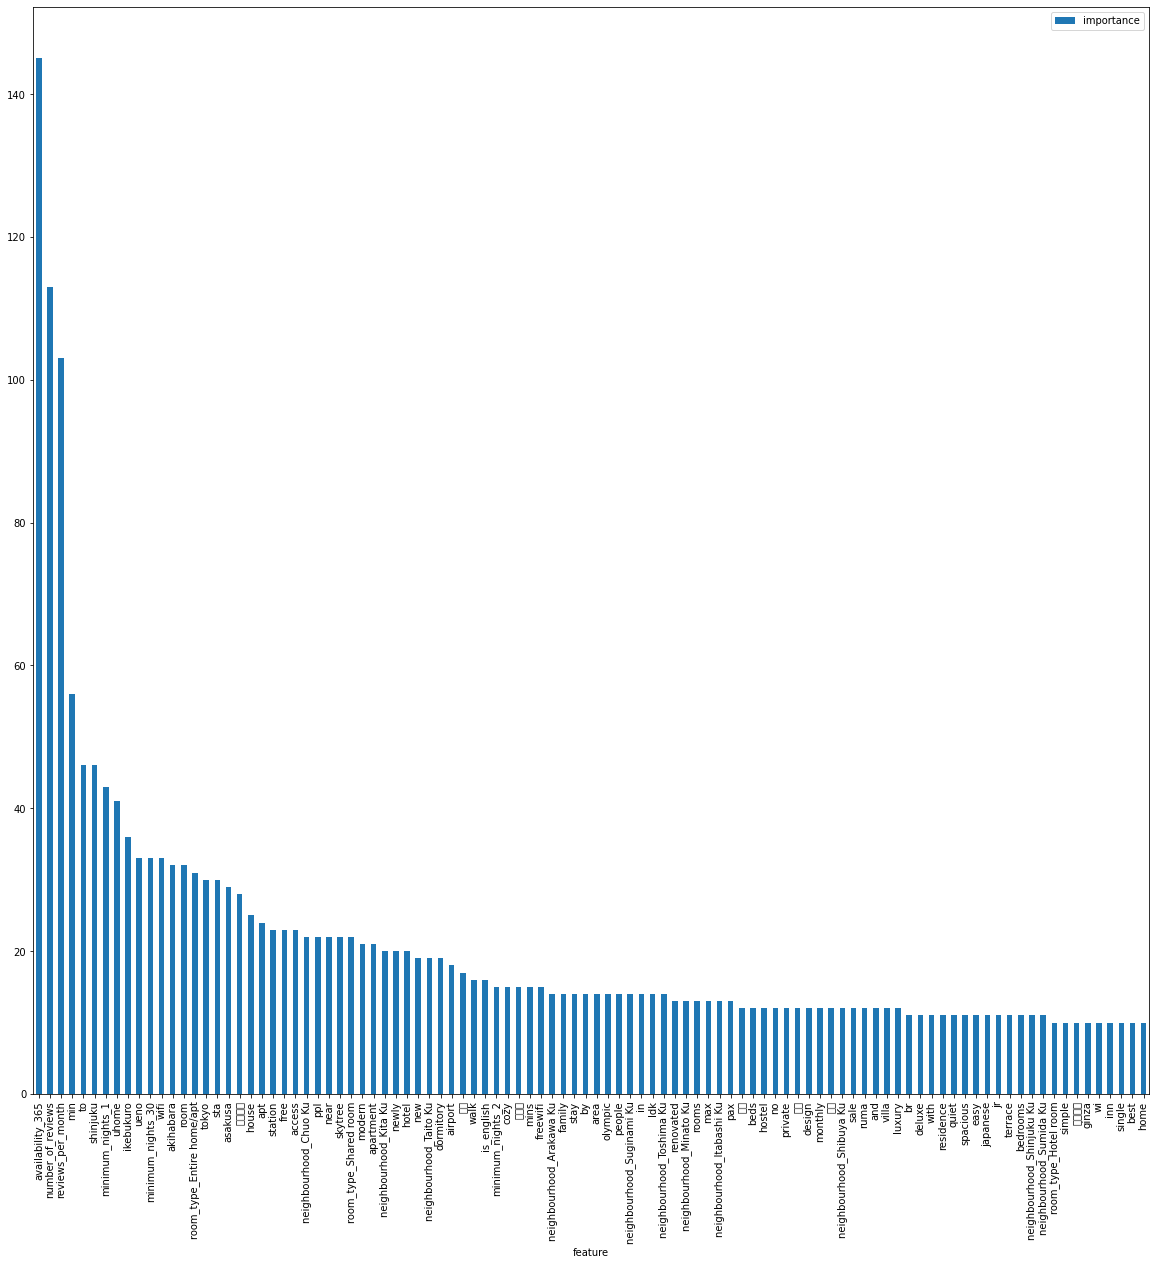

In [26]:
pd.DataFrame({"feature":X_train.columns,"importance":model.feature_importances_}).sort_values("importance",ascending=False).iloc[:100].plot(kind="bar",x="feature",figsize=(20,20))

In [35]:
X_train.columns

Index([ 'number_of_reviews',  'reviews_per_month',   'availability_365',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,
       ...
        'minimum_nights_32',  'minimum_nights_33',  'minimum_nights_35',
        'minimum_nights_60',  'minimum_nights_90',  'minimum_nights_99',
       'minimum_nights_100', 'minimum_nights_180', 'minimum_nights_360',
       'minimum_nights_365'],
      dtype='object', length=4564)